# JAX Bellman Filter Debug

This notebook provides a minimal working example to debug the JAX-based Bellman filter implementation.

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from functions.simulation import DFSV_params, simulate_DFSV
from functions.filters import DFSVBellmanFilter
from functions.filter_bellman import *
from functions.filter_blockopt import *
# Set random seed for reproducibility
np.random.seed(42)

# Create a minimal test model
K = 1  # Number of factors
N = 2  # Number of observed series

# Define model parameters
lambda_r = np.array([[1.0], [0.5]])  # Simple factor loadings
Phi_f = np.array([[0.7]])            # Factor persistence
Phi_h = np.array([[0.95]])           # Volatility persistence
mu = np.array([-1.0])                # Log-volatility mean
sigma2 = np.ones(N) * 0.1            # Measurement noise
Q_h = np.array([[1]])              # Volatility of log-volatility

# Create parameter object
params = DFSV_params(
    N=N,
    K=K,
    lambda_r=lambda_r,
    Phi_f=Phi_f,
    Phi_h=Phi_h,
    mu=mu,
    sigma2=sigma2,
    Q_h=Q_h
)

print("Model parameters created successfully")

Model parameters created successfully


In [2]:
# Generate synthetic data
T = 50  # Just a few time points for testing
y, factors, log_vols = simulate_DFSV(params, T=T, seed=42)

print("Data generated:")
print(f"y shape: {y.shape}")
print(f"factors shape: {factors.shape}")
print(f"log_vols shape: {log_vols.shape}")

Data generated:
y shape: (50, 2)
factors shape: (50, 1)
log_vols shape: (50, 1)


In [3]:
# Initialize the filter
try:
    bf = DFSVBellmanFilter_BlockDiag(params)
    bf2 = DFSVBellmanFilter(params)
    print("\nBellman filter initialized")
    print("\nJAX parameters:")
    print(f"lambda_r shape: {bf.jax_lambda_r.shape}")
    print(f"sigma2 shape: {bf.jax_sigma2.shape}")
    print(f"mu shape: {bf.jax_mu.shape}")
    print(f"Phi_f shape: {bf.jax_Phi_f.shape}")
    print(f"Phi_h shape: {bf.jax_Phi_h.shape}")
    print(f"Q_h shape: {bf.jax_Q_h.shape}")
except Exception as e:
    print(f"Error during initialization: {e}")


Bellman filter initialized

JAX parameters:
lambda_r shape: (2, 1)
sigma2 shape: (2, 2)
mu shape: (1, 1)
Phi_f shape: (1, 1)
Phi_h shape: (1, 1)
Q_h shape: (1, 1)


In [4]:
# Initialize state and test prediction step
try:
    # Initialize state
    state0, cov0 = bf.initialize_state(y)
    print(f"Initial state shape: {state0.shape}")
    print(f"Initial covariance shape: {cov0.shape}")
    print(f"\nInitial state:\n{state0}")
    
    # Test prediction step
    predicted_state, predicted_cov = bf.predict(state0, cov0)
    print("\nPrediction step completed")
    print(f"Predicted state:\n{predicted_state}")
    
    # Verify covariance matrices
    try:
        np.linalg.cholesky(predicted_cov)
        print("\nPredicted covariance is positive definite ✓")
    except np.linalg.LinAlgError:
        print("\nWARNING: Predicted covariance is not positive definite!")
        print("Eigenvalues:", np.linalg.eigvals(predicted_cov))
except Exception as e:
    print(f"Error during prediction: {e}")

Initial state shape: (2, 1)
Initial covariance shape: (2, 2)

Initial state:
[[ 0.]
 [-1.]]

Prediction step completed
Predicted state:
[[ 0.]
 [-1.]]

Predicted covariance is positive definite ✓


In [5]:
# jax.profiler.start_trace(log_dir=logdir)
observation = y[0:1, :].T.reshape(-1, 1)
print(f"Observation shape: {observation.shape}")
print(f"Observation values:\n{observation}")

# Check JAX objective function
print("\nTesting JAX objective function...")
alpha_test = predicted_state.copy()
alpha_test[0]=0.7
# Convert inputs for JAX
jax_alpha = jnp.array(alpha_test)
jax_pred = jnp.array(predicted_state)
jax_I_pred = jnp.array(np.linalg.inv(predicted_cov))
jax_obs = jnp.array(observation)

# Test objective function with new parameter order (removed K, N params)
obj_val, grad_val = bf.obj_and_grad_fn(jax_alpha, jax_pred, jax_I_pred, jax_obs,
                            )
print(f"Objective value at predicted state: {float(obj_val)}")

# Test gradient with new parameter order
print(f"Gradient at predicted state:\n{np.array(grad_val)}")
# Perform update step
print("\nPerforming update step...")

updated_state, updated_cov, log_likelihood = bf.update(
    predicted_state, predicted_cov, observation
)


print("\nUpdate step completed")
print(f"Updated state:\n{updated_state}")
print(f"Log-likelihood: {log_likelihood}")

# Verify updated covariance
try:
    np.linalg.cholesky(updated_cov)
    print("\nUpdated covariance is positive definite ✓")
except np.linalg.LinAlgError:
    print("\nWARNING: Updated covariance is not positive definite!")
    print("Eigenvalues:", np.linalg.eigvals(updated_cov))
# jnp.array(updated_state).block_until_ready()
# jax.profiler.stop_trace()

Observation shape: (2, 1)
Observation values:
[[0.]
 [0.]]

Testing JAX objective function...
Objective value at predicted state: 0.4450045151517471
Gradient at predicted state:
[ 2.71876233 -0.16597887]

Performing update step...

Update step completed
Updated state:
[[ 0.        ]
 [-6.12808834]]
Log-likelihood: 3.070588237202382

Updated covariance is positive definite ✓


In [6]:
#Debug run
y2, _,_ = simulate_DFSV(params, T=500, seed=42)
print("Running full filter...")

filtered_states, filtered_covs, log_likelihood = bf.filter(y)
print("\nFilter completed successfully!")
print(f"Total log-likelihood: {log_likelihood}")
print(f"\nFiltered states shape: {filtered_states.shape}")
print(f"Filtered covs shape: {filtered_covs.shape}")

Running full filter...


Bellman Filter Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Bellman Filter Progress: 100%|██████████| 50/50 [00:00<00:00, 257.22it/s]


Filter completed successfully!
Total log-likelihood: nan

Filtered states shape: (50, 2)
Filtered covs shape: (50, 2, 2)


In [ ]:
print("Running full filter...")

filtered_states, filtered_covs, log_likelihood = bf.filter(y)
print("\nFilter completed successfully!")
print(f"Total log-likelihood: {log_likelihood}")
print(f"\nFiltered states shape: {filtered_states.shape}")
print(f"Filtered covs shape: {filtered_covs.shape}")

# Compare with true states
print("\nCorrelation with true states:")
factor_corr = jnp.corrcoef(filtered_states[:, 0], factors[:, 0])[0, 1]
vol_corr = jnp.corrcoef(filtered_states[:, 1], log_vols[:, 0])[0, 1]
print(f"Factor correlation: {factor_corr:.4f}")
print(f"Log-volatility correlation: {vol_corr:.4f}")

Running full filter...


Bellman Filter Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Bellman Filter Progress: 100%|██████████| 50/50 [00:00<00:00, 219.17it/s]


Filter completed successfully!
Total log-likelihood: nan

Filtered states shape: (50, 2)
Filtered covs shape: (50, 2, 2)

Correlation with true states:
Factor correlation: nan
Log-volatility correlation: nan


In [ ]:
import time
bf2= DFSVBellmanFilter(params)
# Time the JAX implementation
start_time = time.time()
filtered_states_jaxopt, filtered_covs_jaxopt, ll_jaxopt = bf.filter(y)
jaxopt_time = time.time() - start_time
print(f"Optimized implementation time: {jaxopt_time:.4f} seconds")

# Time the original implementation
start_time = time.time()
filtered_states_orig, filtered_covs_orig, ll_orig = bf2.filter(y)
orig_time = time.time() - start_time
print(f"Original implementation time: {orig_time:.4f} seconds")

# Calculate speedup
speedup = orig_time / jaxopt_time if jaxopt_time > 0 else float('inf')
print(f"Speedup factor: {speedup:.2f}x")

# Compare results for consistency
states_diff = np.max(np.abs(filtered_states_jaxopt - filtered_states_orig))
covs_diff = np.max(np.abs(filtered_covs_jaxopt - filtered_covs_orig))
ll_diff = (ll_jaxopt - ll_orig)

print("\nResult consistency check:")
print(f"Max states difference: {states_diff:.8f}")
print(f"Max covariance difference: {covs_diff:.8f}")
print(f"Log-likelihood difference: {ll_diff:.8f}")

Bellman Filter Progress: 100%|██████████| 500/500 [00:01<00:00, 266.09it/s]


Optimized implementation time: 1.8812 seconds


Bellman Filter Progress:  58%|█████▊    | 29/50 [00:14<00:10,  2.01it/s]


KeyboardInterrupt: 

In [8]:
filtered_covs_jaxopt

array([[[ 2.17529598e-03,  0.00000000e+00],
        [ 0.00000000e+00,  1.02544813e+01]],

       [[ 3.28439468e-03,  9.11938132e-03],
        [ 9.11938132e-03,  9.99732814e-01]],

       [[ 7.50227216e-02, -1.13003198e-01],
        [-1.13003198e-01,  1.95030213e+00]],

       [[ 2.26105691e-02, -2.37708191e-02],
        [-2.37708191e-02,  2.73977847e+00]],

       [[ 3.85706541e-02,  3.24930944e-02],
        [ 3.24930944e-02,  5.76660639e-01]],

       [[ 3.58677920e-01,  1.23646031e-01],
        [ 1.23646031e-01,  1.53544190e+00]],

       [[ 1.42500774e-01, -1.47737842e-01],
        [-1.47737842e-01,  2.41289914e+00]],

       [[ 2.52389971e-01,  2.91014831e-01],
        [ 2.91014831e-01,  1.13863382e+00]],

       [[ 1.11086466e+00,  1.62447641e+00],
        [ 1.62447641e+00,  3.39389185e+00]],

       [[ 4.82416851e-01, -4.79403948e-01],
        [-4.79403948e-01,  1.97461837e+00]],

       [[ 8.73590535e-01,  6.08079246e-01],
        [ 6.08079246e-01,  1.28667441e+00]],

       [[ 

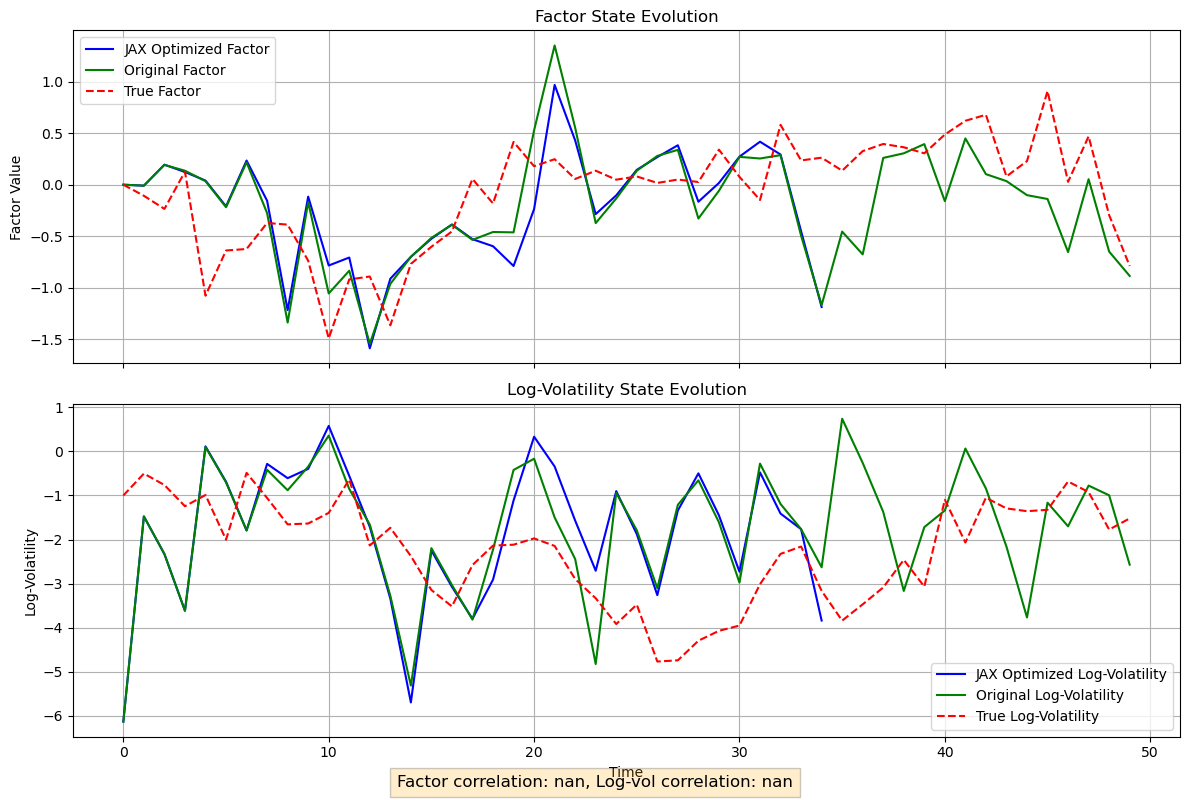

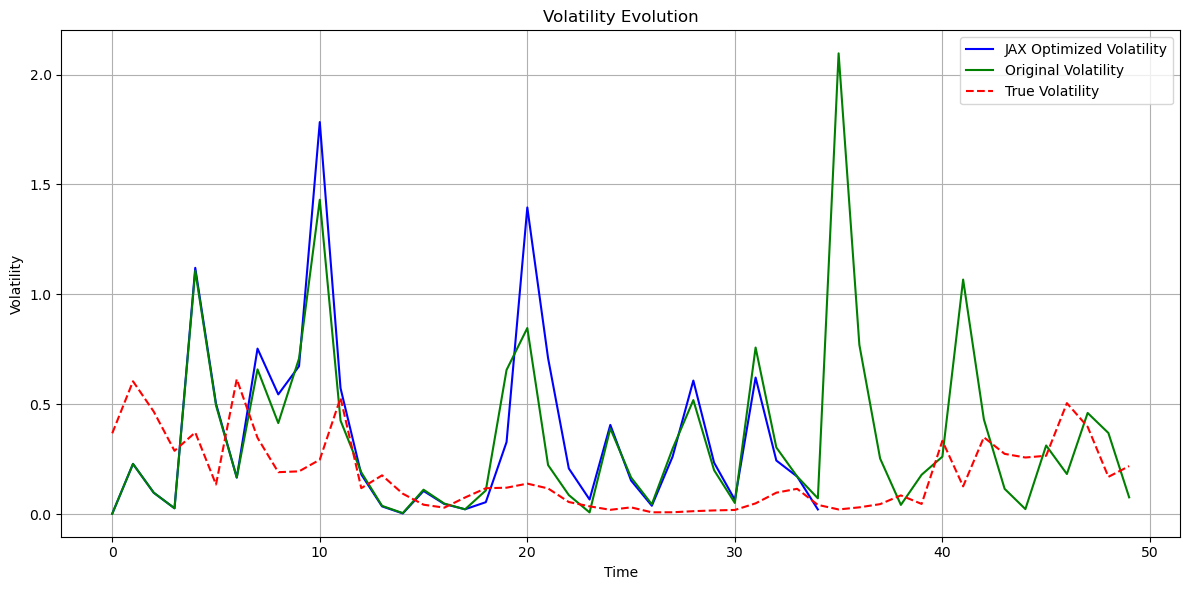

In [11]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot factor states
axes[0].plot(filtered_states_jaxopt[:, 0], 'b-', label='JAX Optimized Factor')
axes[0].plot(filtered_states_orig[:, 0], 'g-', label='Original Factor')
axes[0].plot(factors[:, 0], 'r--', label='True Factor')
axes[0].set_title('Factor State Evolution')
axes[0].set_ylabel('Factor Value')
axes[0].grid(True)
axes[0].legend()

# Plot log-volatility states
axes[1].plot(filtered_states_jaxopt[:, 1], 'b-', label='JAX Optimized Log-Volatility')
axes[1].plot(filtered_states_orig[:, 1], 'g-', label='Original Log-Volatility')
axes[1].plot(log_vols[:, 0], 'r--', label='True Log-Volatility')
axes[1].set_title('Log-Volatility State Evolution')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Log-Volatility')
axes[1].grid(True)
axes[1].legend()

# Also print the correlation values for reference
plt.figtext(0.5, 0.01, f"Factor correlation: {factor_corr:.4f}, Log-vol correlation: {vol_corr:.4f}", 
            ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

plt.tight_layout()
plt.show()

# Create a new figure for volatility (exp of log-volatility)
plt.figure(figsize=(12, 6))
plt.plot(np.exp(filtered_states_jaxopt[:, 1]), 'b-', label='JAX Optimized Volatility')
plt.plot(np.exp(filtered_states_orig[:, 1]), 'g-', label='Original Volatility')
plt.plot(np.exp(log_vols[:, 0]), 'r--', label='True Volatility')
plt.title('Volatility Evolution')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
print(ll_orig)

-137.4457823493863
